<a id='introduction'></a>
<h2>Introduction</h2>
<p>
    Today we have so many laptops in the market<br>
    All with different prices, brands, graphic cards, hard drives types and other specs.<br>
    <br>
    we thought to our selves what affects on the price the most. is it the brand? is it the graphics card? or is it a simple thing like the type of RAM or hard drive? 
    <br>
    Also, could we predict the price of a laptop based on it's specs? which elemnts are critical for that prediction?
    <br>
    To answer the following questions we set a goal to our research to see if we can build a model that will predict the price of a laptop based of it's specs and also to figure out which of the specs affect the price the most.
</p>

<a id='imports'></a>
<h2 id="imports">Imports</h2>

In [562]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from random import randint
import time
from time import sleep
from typing import List
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score


<a id="data_acquisition"></a>
<h2>Data Acquisition</h2>
<p>Considering our options of data acquisition sources, we decided to look for the biggest electronics comparsion websites and scrape data which we thought will be helpful and save it as a dataframe.

The top options we found were:</p>
<ul>
   <li> <a href="https://zap.com/"target="_blank">Zap</a></li>
    <li><a href="https://amazon.com/"target="_blank">Amazon</a></li>
    <li><a href="https://www.ret.co.il/"target="_blank">Ret</a></li>
    <li><a href="https://www.gadgetsnow.com/"target="_blank">gadgetsnow</a></li>
    <li><a href="https://www.wisebuy.co.il/"target="_blank">wisebuy</a></li>
</ul>

<p>After a punctual search in these websites for relevant data and great community scale, we have decided to move on with Zap due to the popularity of the site and amount of features provided for each laptop.</p>




<a id='scraping_challanges'></a>
<h3>Scraping challanges</h3>
<p>While we trying our first attempts to scrape the data from good reads we found out the following issues:<br>
    <ul>
       <li> When sending too many requests in a short period of time, the website started to slow down and the scraping took a long period of time.</li>
        <li>The default user agent used by requests was python: "requests/2.26.0" and we were blocked by Zap after a few requests.</li>
     </ul>
</p>
<p> The way we dealed with those issues was by using sleep and a custom header.

<h3>
Some util functions to help scrape the data:
</h3>
<p>
    <ul>
        <li>sleepms- function made in order to create a delay so the amount of requests sends to the server in parralel will not affect the scraping performance and other users experience in the website</li>
        <li>random_wait- function which is used in order to create random delay so our scraping methodology will not be detected by the servers.</li>
       <li> get_fake_user_agent- function which provides us with a non suspectable user agent.</li>

In [383]:
def sleepms(milliseconds: int):
    seconds = 0.001 * milliseconds
    sleep(seconds)
    
def random_wait():
    start = time.time()
    sleepms(randint(1, 250))

def get_fake_user_agent():
    return {"User-Agent":"PostmanRuntime/7.29.0"}

In [384]:
def string_to_number(string: str,replaces: List [str]):
    #to be continued
    # return number_converter("".join(string.split(",")))
    pass

<a id='scraping_process'></a>
<h3>Scraping Process</h3>
<p>
At first glance at the website we thought to ourselves, just how exactly we want to scrape the data?<br>
So went in to the website and started exploring the website in order to find the best route for our scraping proccess.
</p>
<p>
We could clearly see that our best option to get maximum data was in the extra details page which contains huge amount of data.<br>

</p>

<img src="images/extra_details_page.png"/>

</p>
At this point we asked ourselves what is the exact data we wish to scrape?<br>

we decided to go with the following and rename them for the rest of the process:
<ul>
    <li>יצרן - Brand</li>
    <li>תאריך כניסה לזאפ - Zap Enter Date</li>
    <li>התאמה לגיימינג - Gaming Compability</li>
    <li>מערכת הפעלה - Operating System</li>
    <li>תצורת 2 ב- 1 - Two in One</li>
    <li>משקל - Weight</li>
    <li>סדרה - Series</li>
    <li>סוג מעבד - CPU type</li>
    <li>נפח זיכרון RAM - RAM Capacity</li>
    <li>מהירות מעבד - CPU speed</li>
    <li>דגם מעבד - CPU modal</li>
    <li>דור מעבד - CPU generation</li>
    <li>כונן קשיח - Hard drive capacity</li>
    <li>מהירות כונן קשיח - Hard drive Type</li>
    <li>כונן אופטי - Optical Drive</li>
    <li>גודל מסך - Screen Size</li>
    <li>רזולוצית מסך - Screen Resolution</li>
    <li>סוג מסך - Screen Type</li>
    <li>קצב ריענון תצוגה - FPS</li>
    <li>מסך מגע - Touch Screen</li>
    <li>כרטיס מסך - GPU</li>
    <li>מצלמת רשת - Web camera</li>
    <li>אמצעי אבטחה - Secutiry</li>
    <li>חיבורים - Connectors</li>
    <li>רשת אלחוטית - Wifi modal</li>
    <li>מודם סלולרי - Cellular modem</li>
    <li>מחיר מינימלי - Min price</li>
    <li>מחיר מקסימלי - Max price</li>
</ul>
Also, we decided to save the page number in which Zap decided to place the laptop, we figured it has a meaning we could use:
<ul>
    <li>Page Number</li>
</ul>


In [385]:
def crawl_data(link): 
    page = requests.get(link, headers = get_fake_user_agent())
    soup = BeautifulSoup(page.text, 'html.parser')
    links = soup.findAll ('div', {'class' : 'detailsRow'}, limit=None)
    titles = ['מחיר מינימלי','מחיר מקסימלי']
    spans = soup.find('div','PricesTxt').findAll('span') 
    if len(spans) == 2:
        values = [ spans[1].text, spans[0].text ]
    elif len(spans) == 1: 
        values = [ spans[0].text, spans[0].text ]
    else:
        values = [ None,None ]
    
    for i in range(0, len(links)):
        titles.append(links[i].find('div','detailsRowTitle').text.replace('?','').strip())
        values.append(links[i].find('div','detailsRowTxt').text.strip())


    return dict(zip(titles,values))

In [386]:
def translate_names(df):
    translated_df = pd.DataFrame()
    translation = {
   "יצרן":"Brand",
   "תאריך כניסה לזאפ":"Zap Enter Date",
   "התאמה לגיימינג":"Gaming Compability",
   "מערכת הפעלה":"Operating System",
   "תצורת ‎ 2 in 1":"Two in One",
   "משקל":"Weight",
   "סדרה":"Series",
   "סוג מעבד":"CPU type",
  "נפח זיכרון RAM":"RAM Capacity",
   "מהירות מעבד":"CPU speed",
   "דגם מעבד":"CPU modal",
   "דור מעבד":"CPU generation",
   "כונן קשיח":"Hard drive capacity",
   "מהירות כונן קשיח":"Hard drive Type",
  "כונן אופטי":"Optical Drive",
   "גודל מסך":"Screen Size",
   "רזולוציית מסך":"Screen Resolution",
   "סוג מסך":"Screen Type",
   "קצב רענון תצוגה":"FPS",
   "מסך מגע":"Touch Screen",
   "כרטיס מסך":"GPU",
   "מצלמת רשת":"Web camera",
   "אמצעי אבטחה":"Secutiry",
   "חיבורים":"Connectors",
   "רשת אלחוטית":"Wifi modal",
   "מודם סלולארי":"Cellular modem",
   "מחיר מינימלי":"Min price",
   "מחיר מקסימלי":"Max price",
   "Page Number": "Page number",
   "סוג הזכרון": "Memory type"}

    for key, value in translation.items():
        translated_df[value] = df[key]

    return translated_df

<h3>Crawling</h3>
<p>
add more!
we used selenium...
</p>



In [387]:
def zap_data_crawl_all(BASE_URL,filename,page):
    index = page
    df = pd.DataFrame()
    url = f'{BASE_URL}models.aspx?sog=c:"pclaptop&pageinfo={index}'
    page = requests.get(url,headers = get_fake_user_agent())
    soup = BeautifulSoup(page.text, 'html.parser')
    while soup.select_one('.selectedNumBtn') and soup.select_one('.selectedNumBtn').text == str(index):
        print(f'page number {index}')
        links = soup.findAll ('div', {'class' : 'MoreInfo'}, limit=None)   
        for i in range(0, len(links)):
            link = BASE_URL + links[i].find('a')["href"]
            cd = crawl_data(link)
            cd['מספר עמוד'] = index
            df = pd.concat([df,pd.DataFrame([cd])])
            
        index += 1
        random_wait()
        url = f'{BASE_URL}models.aspx?sog=c:"pclaptop&pageinfo={index}'
        page = requests.get(url,headers = get_fake_user_agent())
        soup = BeautifulSoup(page.text, 'html.parser')
    translated_df = translate_names(df)
    translated_df.to_csv(filename, index=False ,encoding = 'utf:"8:"sig')

In [388]:
BASE_URL ="https://www.zap.co.il/"
filename = 'laptops_data.csv'
page = 1

In [389]:
zap_data_crawl_all(BASE_URL, filename, page)

KeyError: 'יצרן'

<a id='data_scraped'></a>
<h3>Let's check how much data did we scrape before we start cleaning it (if needed)</h3>

In [595]:
laptops_df = pd.read_csv(filename)
print(f"df shape:{laptops_df.shape}")
print(f"data amount before cleaning: {'{:,}'.format(laptops_df.shape[0] * laptops_df.shape[1])} (rows * cols)")
laptops_df.head(10)

df shape:(3112, 30)
data amount before cleaning: 93,360 (rows * cols)


,Brand,Zap Enter Date,Gaming Compability,Operating System,Two in One,Weight,Series,CPU type,RAM Capacity,CPU speed,...,GPU,Web camera,Secutiry,Connectors,Wifi modal,Cellular modem,Min price,Max price,Page number,Memory type
0,Apple,2021,גיימינג,MacOS,ללא,"1.29 ק""ג",MacBook Air,M1,8 GB,לא זמין,...,לא זמין,1 מגה פיקסל,קורא טביעות אצבע,"DisplayPort , Thunderbolt , USB-C , Bluetooth ...","WiFi 6 , 802.11ax",לא כולל,"3,698","5,108",1,לא זמין
1,Lenovo,2021,גיימינג,ללא,ללא,"1.85 ק""ג",V14 ADA,AMD,4 GB,לא זמין,...,Integrated AMD Radeon Graphics,לא זמין,לא כולל,"Card Reader , אוזניות/מיקרופון , HDMI , Blueto...",802.11ac,לא כולל,970,"1,970",1,DDR4
2,Lenovo,מ 2022,גיימינג,ללא,ללא,"1.7 ק""ג",ThinkBook 15 G2,Intel Core i7,16 GB,2800Mhz,...,Integrated Intel Iris Xe Graphics,1 מגה פיקסל,לא כולל,"RJ-45 , DisplayPort , Thunderbolt , Card Reade...","WiFi 6 , 802.11ax",לא כולל,"2,849","3,820",1,DDR4
3,Asus,2021,גיימינג,ללא,ללא,"1.8 ק""ג",לא רלוונטי,Intel Core i3,16 GB,3000Mhz,...,Intel Iris Xe Graphics,כולל,לא כולל,"אוזניות/מיקרופון , USB-C , HDMI , Bluetooth , USB",802.11ac,לא כולל,"1,599","2,263",1,DDR4
4,Apple,2021,גיימינג,MacOS,ללא,"1.6 ק""ג",MacBook Pro,M1,16 GB,לא זמין,...,לא זמין,כולל,קורא טביעות אצבע,"DisplayPort , Thunderbolt , אוזניות/מיקרופון ,...","WiFi 6 , 802.11ax",לא כולל,"7,421","8,166",1,לא זמין
5,Lenovo,2020,גיימינג,ללא,ללא,"1.6 ק""ג",לא רלוונטי,AMD,4 GB,1200Mhz,...,Integrated AMD Radeon Graphics,כולל,לא כולל,"Card Reader , אוזניות/מיקרופון , HDMI , Blueto...",802.11ac,לא כולל,815,"1,710",1,DDR4
6,Lenovo,מ 2022,גיימינג,Windows 11 Home,מסך מסתובב,"1.5 ק""ג",IdeaPad Flex 5,Intel Core i5,8 GB,2400Mhz,...,Integrated Intel Iris Xe Graphics,1 מגה פיקסל,קורא טביעות אצבע,"Card Reader , אוזניות/מיקרופון , USB-C , HDMI ...",802.11ax,לא כולל,"2,699","3,519",1,DDR4
7,Asus,2021,גיימינג,Windows 10 PRO,ללא,"1.2 ק""ג",לא רלוונטי,Intel Celeron,4 GB,1100Mhz,...,לא זמין,כולל,לא זמין,"Card Reader , אוזניות/מיקרופון , HDMI , Blueto...",802.11ac,לא כולל,865,"1,290",1,DDR3
8,Apple,2021,גיימינג,MacOS,ללא,"1.29 ק""ג",MacBook Air,M1,16 GB,לא זמין,...,לא זמין,1 מגה פיקסל,לא כולל,"DisplayPort , Thunderbolt , אוזניות/מיקרופון ,...",כולל,לא כולל,"4,506","4,998",1,לא זמין
9,Apple,2021,גיימינג,MacOS,ללא,"1.4 ק""ג",MacBook Pro,M1,8 GB,לא זמין,...,לא זמין,1 מגה פיקסל,קורא טביעות אצבע,"Thunderbolt , אוזניות/מיקרופון , USB-C , Bluet...","WiFi 6 , 802.11ax",לא כולל,"4,849","5,548",1,לא זמין


<a id='data_cleaning'></a>
<h2>Data Cleaning</h2>


<h3>Turning Zap's NA's to real NA's</h3>

In [596]:
laptops_real_na = laptops_df.copy()
for col in laptops_real_na:
    laptops_real_na.loc[(laptops_real_na[col] == 'לא זמין') | (laptops_real_na[col] == 'יעודכן בקרוב') | (laptops_real_na["Memory type"] == "לא רלוונטי"), col] = None 

<h3>Cleaning and converting to numeric</h3>

In [597]:
def cleaning_and_converting(df):
    df['Zap Enter Date'] = pd.to_numeric(df['Zap Enter Date'].str.replace('מ','').str.replace('עד','').str.strip())
    df['RAM Capacity'] = pd.to_numeric(df['RAM Capacity'].str.replace('GB','').str.strip())
    df['CPU speed'] = pd.to_numeric(df['CPU speed'].str.replace('Mhz','').str.replace('MHz','').str.strip())
    df['CPU generation'] = pd.to_numeric(df['CPU generation'].str.replace('דור','').str.strip())
    df['Screen Size'] = pd.to_numeric(df['Screen Size'].str.replace('אינטש','').str.strip())
    df["FPS"] = pd.to_numeric(df["FPS"].str.lower().str.replace('hz','').str.strip())
    
    df["Memory type"] = pd.to_numeric(df["Memory type"].str.replace('DDR','').str.strip())
    
    df['Hard drive capacity'] = df['Hard drive capacity'].str.replace('GB','').str.strip()
    for i in range(len(df['Hard drive capacity'])):
        if not df.loc[i, 'Hard drive capacity']:
            continue
        arr = df.loc[i, 'Hard drive capacity'].replace(",","+").split("+")
        if len(arr) > 1:
            sum = 0
            for num in arr:
                sum += int(num)
            df.loc[i, 'Hard drive capacity'] = sum
        else:
            df.loc[i, 'Hard drive capacity'] = int(arr[0])

    
    df['Screen Resolution'] = df['Screen Resolution'].str.replace('X','x')
    df['Weight'] = df['Weight'].str.replace('ק"ג','').str.strip()
    df['Weight']= pd.to_numeric(df['Weight'])
    
    df['Max price'] = pd.to_numeric(df['Max price'].str.replace(',',''))
    df['Min price'] = pd.to_numeric(df['Min price'].str.replace(',','' ))

cleaning_and_converting(laptops_real_na)


<h3>Converting to Categorical</h3>

In [598]:
laptops_real_na["Touch Screen"] =  np.where(laptops_real_na['Touch Screen']  == "כולל" , 1 , 0)

<h3>Removing Duplicates</h3>

In [599]:
laptops_no_dup = laptops_real_na[~laptops_real_na.duplicated()]


<p>Lets see how many rows did we lose and the NA count:</p>

In [600]:
laptops_no_dup.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3111 entries, 0 to 3111
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                3110 non-null   object 
 1   Zap Enter Date       3110 non-null   float64
 2   Gaming Compability   2833 non-null   object 
 3   Operating System     2836 non-null   object 
 4   Two in One           2825 non-null   object 
 5   Weight               2809 non-null   float64
 6   Series               2780 non-null   object 
 7   CPU type             2856 non-null   object 
 8   RAM Capacity         2864 non-null   float64
 9   CPU speed            2695 non-null   float64
 10  CPU model            2760 non-null   object 
 11  CPU generation       2739 non-null   float64
 12  Hard drive capacity  2867 non-null   object 
 13  Hard drive Type      2810 non-null   object 
 14  Optical Drive        2825 non-null   object 
 15  Screen Size          2862 non-null   f

<p>It looks like we didn't have any duplicates. so lets continue reviewing the NA's:</p>

In [601]:
laptops_no_dup.describe()

,Zap Enter Date,Weight,RAM Capacity,CPU speed,CPU generation,Screen Size,FPS,Touch Screen,Min price,Max price,Page number,Memory type
count,3110.000000,2809.000000,2864.000000,2695.000000,2739.000000,2862.000000,2731.000000,3111.000000,3110.000000,3110.000000,3110.000000,2636.000000
mean,2021.058199,1.703326,14.337291,2584.537662,10.054399,14.810307,69.856829,0.180328,5465.478778,5864.659486,65.322508,3.995448
std,0.839762,0.438913,8.047496,681.016020,2.030348,1.107618,34.027327,0.384522,3198.642820,3330.792721,37.441304,0.180601
min,2017.000000,0.340000,2.000000,933.000000,2.000000,10.300000,60.000000,0.000000,799.000000,889.000000,1.000000,3.000000
25%,2021.000000,1.400000,8.000000,2400.000000,10.000000,14.000000,60.000000,0.000000,3190.000000,3490.000000,33.000000,4.000000
50%,2021.000000,1.650000,16.000000,2500.000000,11.000000,15.600000,60.000000,0.000000,4549.000000,4990.000000,65.000000,4.000000
75%,2022.000000,1.900000,16.000000,2800.000000,11.000000,15.600000,60.000000,0.000000,6893.000000,7369.750000,98.000000,4.000000
max,2022.000000,4.630000,64.000000,5000.000000,12.000000,17.300000,300.000000,1.000000,25361.000000,25361.000000,130.000000,5.000000


<p>
it looks like the following coulmns are lacking in data:
<ul>
<strong>
<li>CPU model</li>
<li>Gaming compability</li>
<li>CPU generation</li>
<li>GPU</li>
<li>CPU speed</li>
<li>Memory type</li>
</strong>
</ul>

</p>

<a id='none_values'></a>
<p>
    Let's check how many total books are there without any NA values:
</p>    

In [602]:
laptops_no_dup.dropna(how='any').info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1905 entries, 3 to 3111
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                1905 non-null   object 
 1   Zap Enter Date       1905 non-null   float64
 2   Gaming Compability   1905 non-null   object 
 3   Operating System     1905 non-null   object 
 4   Two in One           1905 non-null   object 
 5   Weight               1905 non-null   float64
 6   Series               1905 non-null   object 
 7   CPU type             1905 non-null   object 
 8   RAM Capacity         1905 non-null   float64
 9   CPU speed            1905 non-null   float64
 10  CPU model            1905 non-null   object 
 11  CPU generation       1905 non-null   float64
 12  Hard drive capacity  1905 non-null   object 
 13  Hard drive Type      1905 non-null   object 
 14  Optical Drive        1905 non-null   object 
 15  Screen Size          1905 non-null   f

<p>Almost a third missing! thats not good...</p>
<p>First, by looking at the data it seems like <strong>Gaming compability</strong> and <strong>CPU model</strong> are unnecessary. so, we would like to remove them:</p>

In [603]:
laptops_no_dup = laptops_no_dup.drop(["CPU model","Gaming Compability" ] , axis = 1) 
laptops_no_dup.dropna(how='any').info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2158 entries, 3 to 3111
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                2158 non-null   object 
 1   Zap Enter Date       2158 non-null   float64
 2   Operating System     2158 non-null   object 
 3   Two in One           2158 non-null   object 
 4   Weight               2158 non-null   float64
 5   Series               2158 non-null   object 
 6   CPU type             2158 non-null   object 
 7   RAM Capacity         2158 non-null   float64
 8   CPU speed            2158 non-null   float64
 9   CPU generation       2158 non-null   float64
 10  Hard drive capacity  2158 non-null   object 
 11  Hard drive Type      2158 non-null   object 
 12  Optical Drive        2158 non-null   object 
 13  Screen Size          2158 non-null   float64
 14  Screen Resolution    2158 non-null   object 
 15  Screen Type          2158 non-null   o

<p>Not a big improvement... lets try filling-in the rest:</p>


<h3>First, lets try filling-in <strong>CPU generation</strong>:</h3>
<h4>Mean or Median?</h4>
<p>
    In order to decide in which metric to replace <strong>CPU generation</strong> (mean/median) we want to replace NA values we wanted to base our decision over the distribution of the metric.
</p>

2.0
12.0


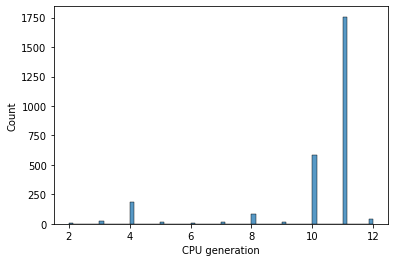

In [604]:
print(laptops_no_dup['CPU generation'].min())
print(laptops_no_dup['CPU generation'].max())

sns.histplot(laptops_no_dup['CPU generation'])
plt.show()

<p>it seems like 11 is the right choice to fill-in the NA's so we'll go with that</p>

In [605]:
most_freq_CPU_generation = laptops_no_dup['CPU generation'].mode()[0]
laptops_no_dup['CPU generation'] = laptops_no_dup['CPU generation'].fillna(most_freq_CPU_generation)


<h3>Lets do the same for <strong>CPU speed</strong>:</h3>


933.0
5000.0


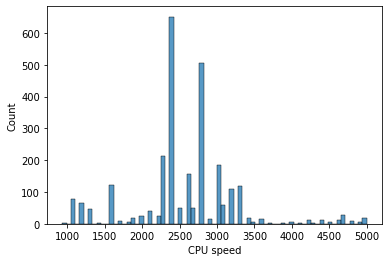

In [606]:
print(laptops_no_dup['CPU speed'].min())
print(laptops_no_dup['CPU speed'].max())

sns.histplot(laptops_no_dup['CPU speed'])
plt.show()

<p>
As can be seen, the distribution can show us that there are not so many outliers.
So we are going to use mean.
</p>

In [607]:
cpu_speed_mean = laptops_no_dup['CPU speed'].mean()

laptops_no_dup['CPU speed'] = np.where(
    laptops_no_dup['CPU speed'].isnull(),
    cpu_speed_mean,
    laptops_no_dup['CPU speed']
)


<h3>Now, lets try filling-in <strong>GPU</strong> and <strong>Memory type</strong>:</h3>
<p>
  GPU and Memory type are string values, so we'll do the same for them:
</p>

In [608]:
most_freq_GPU = laptops_no_dup['GPU'].mode()[0]
laptops_no_dup['GPU'] = laptops_no_dup['GPU'].fillna(most_freq_GPU)

most_freq_memory_type = laptops_no_dup['Memory type'].mode()[0]
laptops_no_dup['Memory type'] = laptops_no_dup['Memory type'].fillna(most_freq_memory_type)


<p>lets see how that went for us:</p>

In [609]:
laptops_no_dup.dropna(how='any').info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2428 entries, 0 to 3111
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                2428 non-null   object 
 1   Zap Enter Date       2428 non-null   float64
 2   Operating System     2428 non-null   object 
 3   Two in One           2428 non-null   object 
 4   Weight               2428 non-null   float64
 5   Series               2428 non-null   object 
 6   CPU type             2428 non-null   object 
 7   RAM Capacity         2428 non-null   float64
 8   CPU speed            2428 non-null   float64
 9   CPU generation       2428 non-null   float64
 10  Hard drive capacity  2428 non-null   object 
 11  Hard drive Type      2428 non-null   object 
 12  Optical Drive        2428 non-null   object 
 13  Screen Size          2428 non-null   float64
 14  Screen Resolution    2428 non-null   object 
 15  Screen Type          2428 non-null   o

In [610]:
laptop_eda = laptops_no_dup.copy().dropna(how='any') 

<p>we saved 500 rows! what a success!</p>


<h3>Min price, Max price to just Price!</h3>
<p>
    currently, Zap provided us with <strong>Min Price</strong> and <strong>Max Price</strong><br>
    but for our predictions we will need only <strong>Price</strong>.
</p>

In [611]:
laptop_eda['Price'] = (laptop_eda['Max price'] + laptop_eda['Min price'])/2
laptop_eda['Price'] = (laptop_eda['Price'] - laptop_eda['Price'].min()) / (laptop_eda['Price'].max() - laptop_eda['Price'].min())
laptop_eda = laptop_eda.drop(["Max price" , "Min price" ] , axis = 1) 

<h1>EDA</h1>

<p>
    <ul>
        <li>create_heatmap - a function made in order to create and display a heatmap.</li>

In [624]:
def create_heatmap(numeric_df):
    first_col = numeric_df.pop('Price')
    numeric_df.insert(0, 'Price', first_col)
    sns.heatmap(numeric_df.corr())

<a id='brands_distribution'></a>
<h3>Numeric fields Correlation to Price</h3>
<p>We would like now to create a heatmap in order to check the correlation of the numeric values on the price:</p>

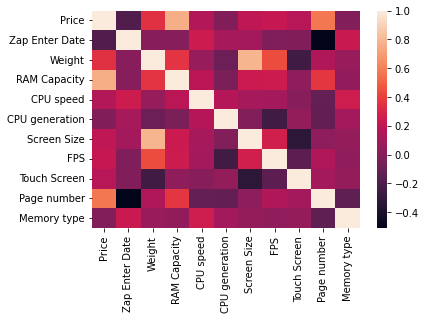

In [625]:
laptops_for_heatmap = laptop_eda.select_dtypes(include='number')
create_heatmap(laptops_for_heatmap)

<p>As we can see, the numeric values alone won't help us in our research. but, it seems like we should look into <strong>Ram capacity</strong> and <strong>Page Number</strong>.</p>

<a id='brands_distribution'></a>
<h3>Ram Capacity distribution</h3>

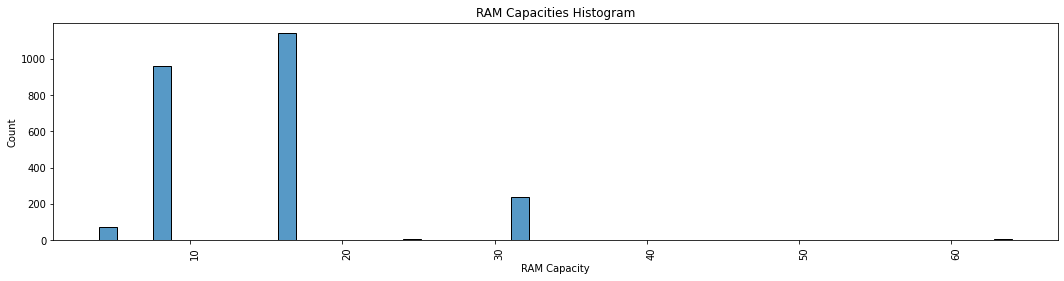

In [626]:
fig, ax = plt.subplots(figsize=(18, 4))
fg = sns.histplot(laptop_eda['RAM Capacity'], ax=ax)
fg.set_title("RAM Capacities Histogram")
fg.set_xlabel("RAM Capacity")
plt.xticks(rotation=90, ha='right', rotation_mode='anchor')
plt.show()

<p>it seems that most laptops use 8 or 16 GB of RAM.</p>

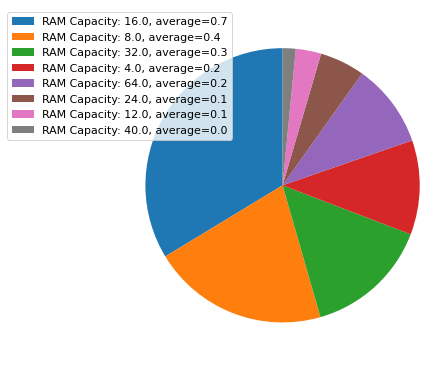

In [629]:
ram_capacity_counts = laptop_eda['RAM Capacity'].value_counts()
laptops_price_mean_by_ram_capacity = laptop_eda.groupby('RAM Capacity', as_index=False)['Price'].mean()
laptops_price_mean_by_ram_capacity.sort_values(by="Price", inplace=True, ascending=False)

labels = ["RAM Capacity: %s" % i for i in ram_capacity_counts.index]

fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)

_, _ = ax1.pie(laptops_price_mean_by_ram_capacity['Price'].tolist(), startangle=90)

ax1.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, average=%1.1f' % (
        l, (v)) for l, s, v in zip(labels, laptops_price_mean_by_ram_capacity.index, laptops_price_mean_by_ram_capacity['Price'].tolist())],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()

<p>We can learn from this graph that high priced laptops use 8 and 16 GB RAM. due to their distrabution we assume it's because of their populatiry</p>

In [ ]:
data = [44, 45, 40, 41, 39]
keys = ['Class 1', 'Class 2', 'CLass 3', 'Class 4', 'Class 5']
  
# define Seaborn color palette to use
palette_color = seaborn.color_palette('bright')
  
# plotting data on chart
plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
  
# displaying chart
plt.show()

<a id='brands_distribution'></a>
<h3>Brands distribution</h3>

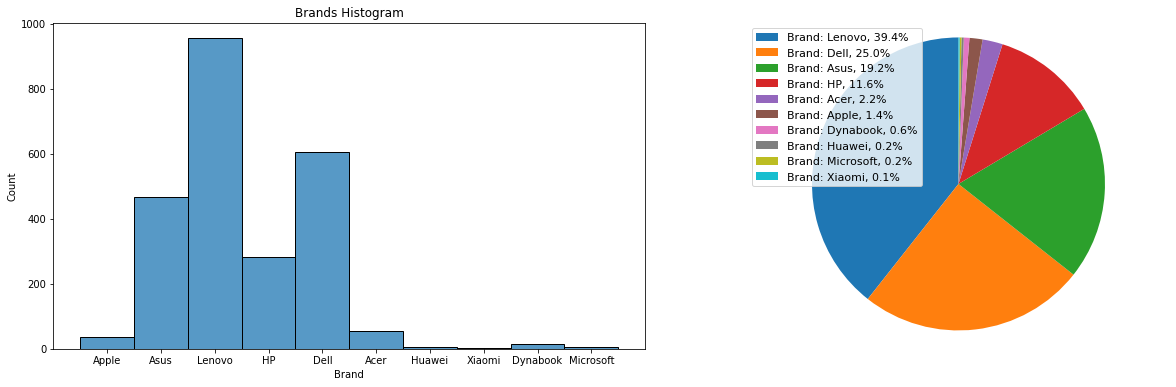

In [612]:

fig = plt.figure(figsize=(20, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[3.5, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


#histogram:
fg = sns.histplot(laptop_eda['Brand'], ax=ax1)
fg.set_title("Brands Histogram")
fg.set_xlabel("Brand")
plt.xticks(rotation=90, ha='right', rotation_mode='anchor')

laptopts_by_brand_count = laptop_eda['Brand'].value_counts()

total_laptops = laptop_eda.shape[0]

labels = ["Brand: %s" % i for i in laptopts_by_brand_count.index]

#pie chart:
_, _ = ax2.pie(laptopts_by_brand_count.values, startangle=90)

ax2.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, %1.1f%%' % (
        l, (v / total_laptops * 100)) for l, s, v in zip(labels, laptopts_by_brand_count.index, laptopts_by_brand_count.values)],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    # bbox_transform=fig1.transFigure
)
plt.show()

<p>as can be seen, Lenovo, Asus, Dell and HP are the largest "players" in the market. and Apple and Acer also take a small portion of the market</p><br>
<p>this also checks out with a simple google search:</p>

<img width="50%" height="50%" style="margin-right:5px" src="images/laptop_market_share_1.png"/><img src="images/laptop_market_share_2.png"/>

<a id='mean_price_by_brand_'></a>

<h3>Mean price by brand</h3>

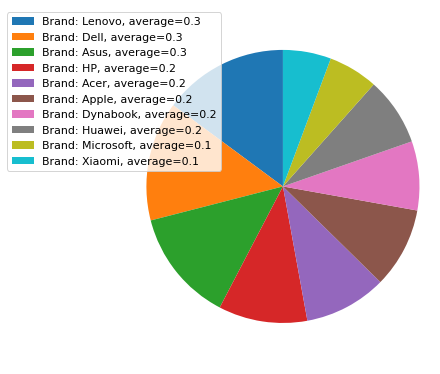

In [613]:
laptops_price_mean_by_brand = laptop_eda.groupby('Brand', as_index=False)['Price'].mean()
laptops_price_mean_by_brand.sort_values(by="Price", inplace=True, ascending=False)

labels = ["Brand: %s" % i for i in laptopts_by_brand_count.index]

fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)

_, _ = ax1.pie(laptops_price_mean_by_brand['Price'].tolist(), startangle=90)

ax1.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, average=%1.1f' % (
        l, (v)) for l, s, v in zip(labels, laptops_price_mean_by_brand.index, laptops_price_mean_by_brand['Price'].tolist())],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()


<a id='genre_distribution'></a>
<h3>Screen size distribution</h3>

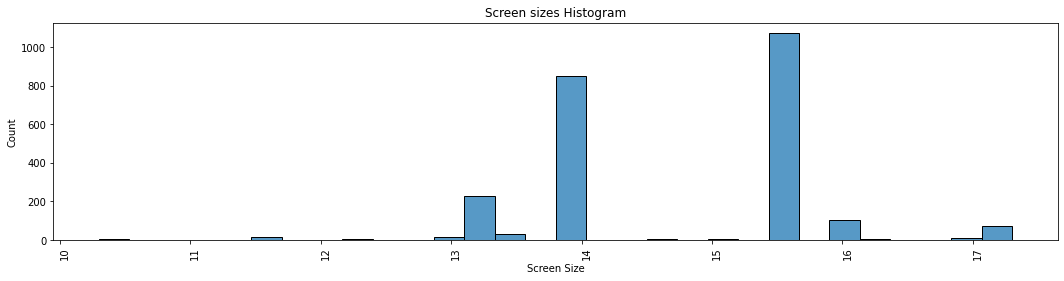

In [614]:
fig, ax = plt.subplots(figsize=(18, 4))
fg = sns.histplot(laptop_eda['Screen Size'], ax=ax)
fg.set_title("Screen sizes Histogram")
fg.set_xlabel("Screen Size")
plt.xticks(rotation=90, ha='right', rotation_mode='anchor')
plt.show()

<p>It's easy to see that 15.6 inches and 14 inches make most of the market. next, we'll check if screen size affects the price.</p>

<a id='mean_price_by_brand_'></a>

<h3>Mean price by screen size</h3>

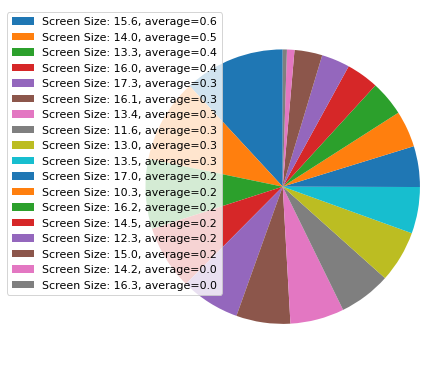

In [615]:
laptopts_by_screen_size_count = laptop_eda['Screen Size'].value_counts()

laptops_price_mean_by_screen_size = laptop_eda.groupby('Screen Size', as_index=False)['Price'].mean()
laptops_price_mean_by_screen_size.sort_values(by="Price", inplace=True, ascending=False)

labels = ["Screen Size: %s" % i for i in laptopts_by_screen_size_count.index]

fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)

_, _ = ax1.pie(laptops_price_mean_by_screen_size['Price'].tolist(), startangle=90)

ax1.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, average=%1.1f' % (
        l, (v)) for l, s, v in zip(labels, laptops_price_mean_by_screen_size.index, laptops_price_mean_by_screen_size['Price'].tolist())],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()


<p>It seems that the screen size does affect the price, but considering that 15.5 and 14 inches make most of the market it's not suprising.</p>

<a id='machine_learning_prep'></a>
<h1>Machine Learning</h1>

In [630]:
def train_1st_model(X_train, y_train):
    reg = LinearRegression(fit_intercept = False)
    return reg.fit(X_train,y_train)

In [631]:
def predict_1st(trained_1st_model, X_test):
    return trained_1st_model.predict(X_test)

In [632]:
def evaluate_performance_1st(y_test,y_predicted):
    return metrics.r2_score(y_test,y_predicted)

In [633]:
def load_dataset(df, target_column):
    return df.drop([target_column],axis = 1),df[target_column]

In [638]:
def predict(df):
    numeric_df = df.select_dtypes(include='number')
    X_1st_train, y_1st_train = load_dataset(numeric_df,'Price')
    X_1st_test, y_1st_test = load_dataset(numeric_df, 'Price')
    trained_model_1st = train_1st_model(X_1st_train, y_1st_train)
    pred_1st_vals = predict_1st(trained_model_1st, X_1st_test)
    y_pred_1st= pd.Series(pred_1st_vals,index=X_1st_test.index)
    eval_res_1st = evaluate_performance_1st(y_1st_test, y_pred_1st)
    return eval_res_1st

In [639]:
before = laptop_eda.copy()
print('prediction:', predict(before))

prediction: 0.7127942295068155
